In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


In [2]:
df=pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [39]:
df.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'lat', 'long',
       'city_pop', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'hour', 'day', 'month', 'weekday', 'distance', 'is_night',
       'is_high_amt', 'category_encoded'],
      dtype='object')

In [4]:
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])
df['hour']=df['trans_date_trans_time'].dt.hour
df['day']=df['trans_date_trans_time'].dt.day
df['month']=df['trans_date_trans_time'].dt.month
df['weekday'] = df['trans_date_trans_time'].dt.weekday

In [5]:
drop_colum=['Unnamed: 0','trans_date_trans_time','first','last','street','city','state','zip','job','trans_num']
df=df.drop(columns=drop_colum)

In [6]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,weekday
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,1325376018,36.011293,-82.048315,0,0,1,1,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,1325376044,49.159047,-118.186462,0,0,1,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,1325376051,43.150704,-112.154481,0,0,1,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,1325376076,47.034331,-112.561071,0,0,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,1325376186,38.674999,-78.632459,0,0,1,1,1


In [9]:
df['distance'] = df.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1)

In [10]:
df['is_night'] = df['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

In [11]:
# High Amount Flag
high_amt_thresh = df['amt'].quantile(0.95)
df['is_high_amt'] = df['amt'].apply(lambda x: 1 if x > high_amt_thresh else 0)


In [12]:

# Encode categorical variable if present
if 'category' in df.columns:
    df['category_encoded'] = LabelEncoder().fit_transform(df['category'])

In [13]:
# Drop unnecessary columns
drop_columns = ['Unnamed: 0','trans_date_trans_time','first','last','street','city','state','zip','job','trans_num']
drop_columns = [col for col in drop_columns if col in df.columns]  # handle missing columns safely
df = df.drop(columns=drop_columns)

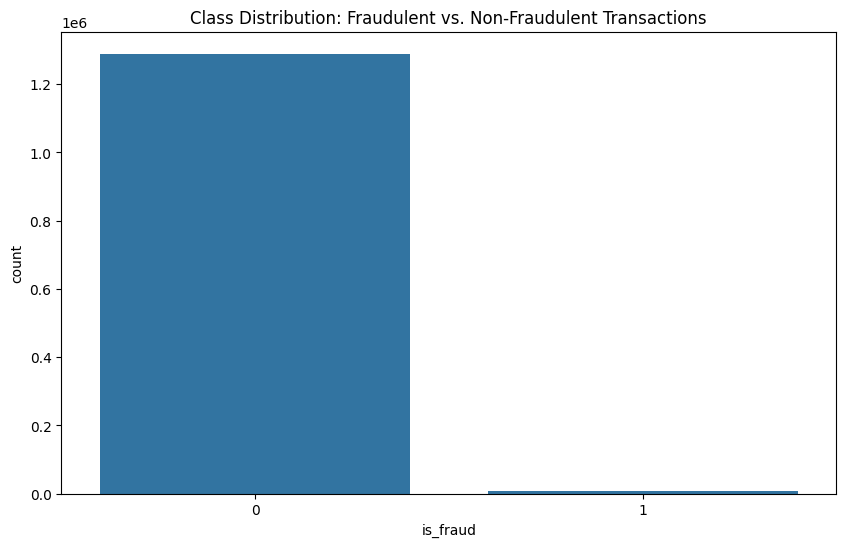

In [14]:
# Data Visualizations
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='is_fraud')
plt.title('Class Distribution: Fraudulent vs. Non-Fraudulent Transactions')
plt.show()

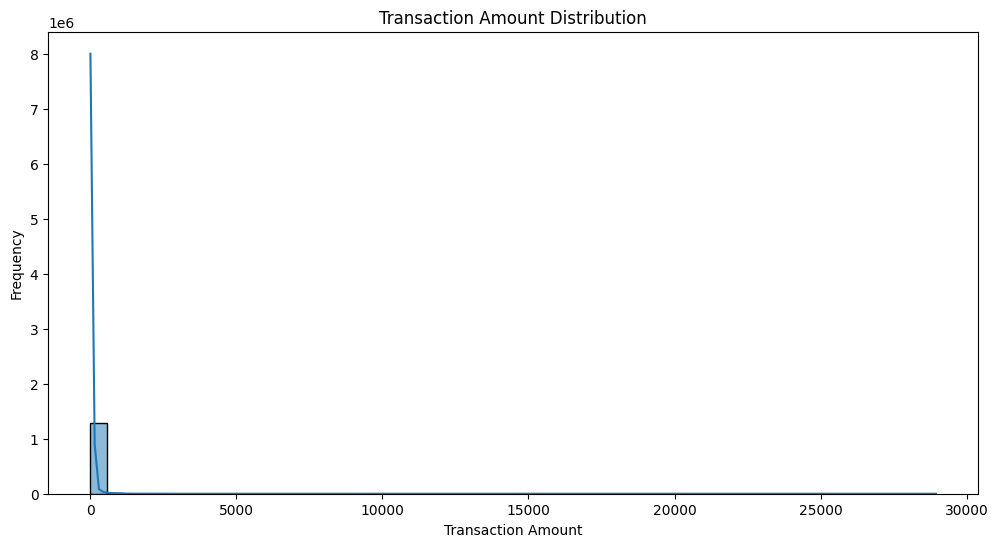

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(df['amt'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

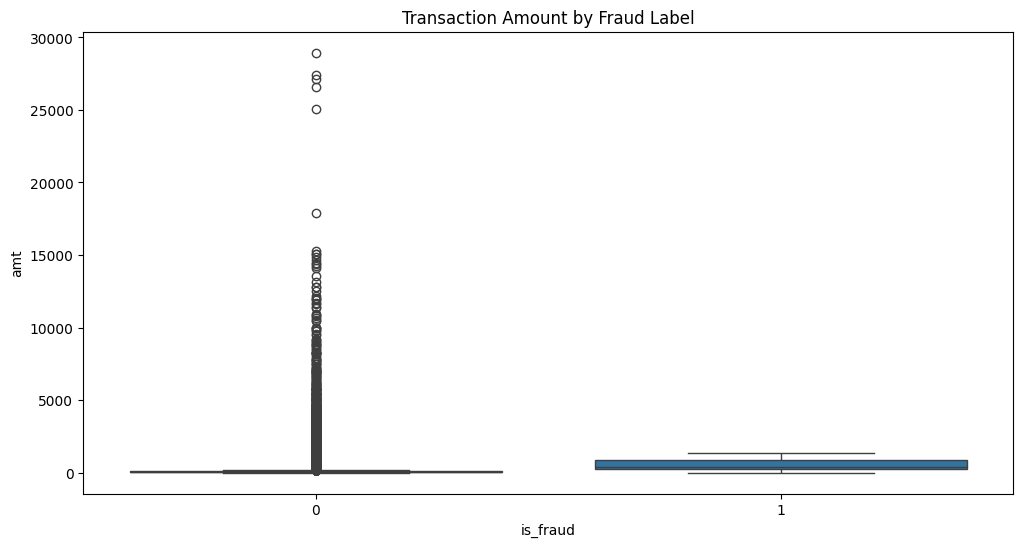

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='is_fraud', y='amt')
plt.title('Transaction Amount by Fraud Label')
plt.show()

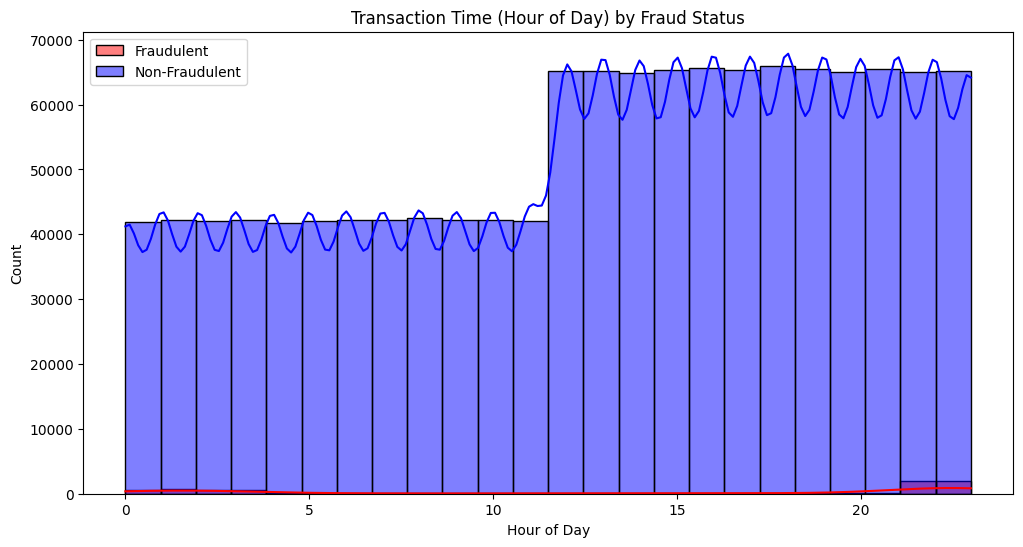

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['is_fraud'] == 1]['hour'], bins=24, color='red', label='Fraudulent', kde=True)
sns.histplot(df[df['is_fraud'] == 0]['hour'], bins=24, color='blue', label='Non-Fraudulent', kde=True)
plt.title('Transaction Time (Hour of Day) by Fraud Status')
plt.xlabel('Hour of Day')
plt.legend()
plt.show()

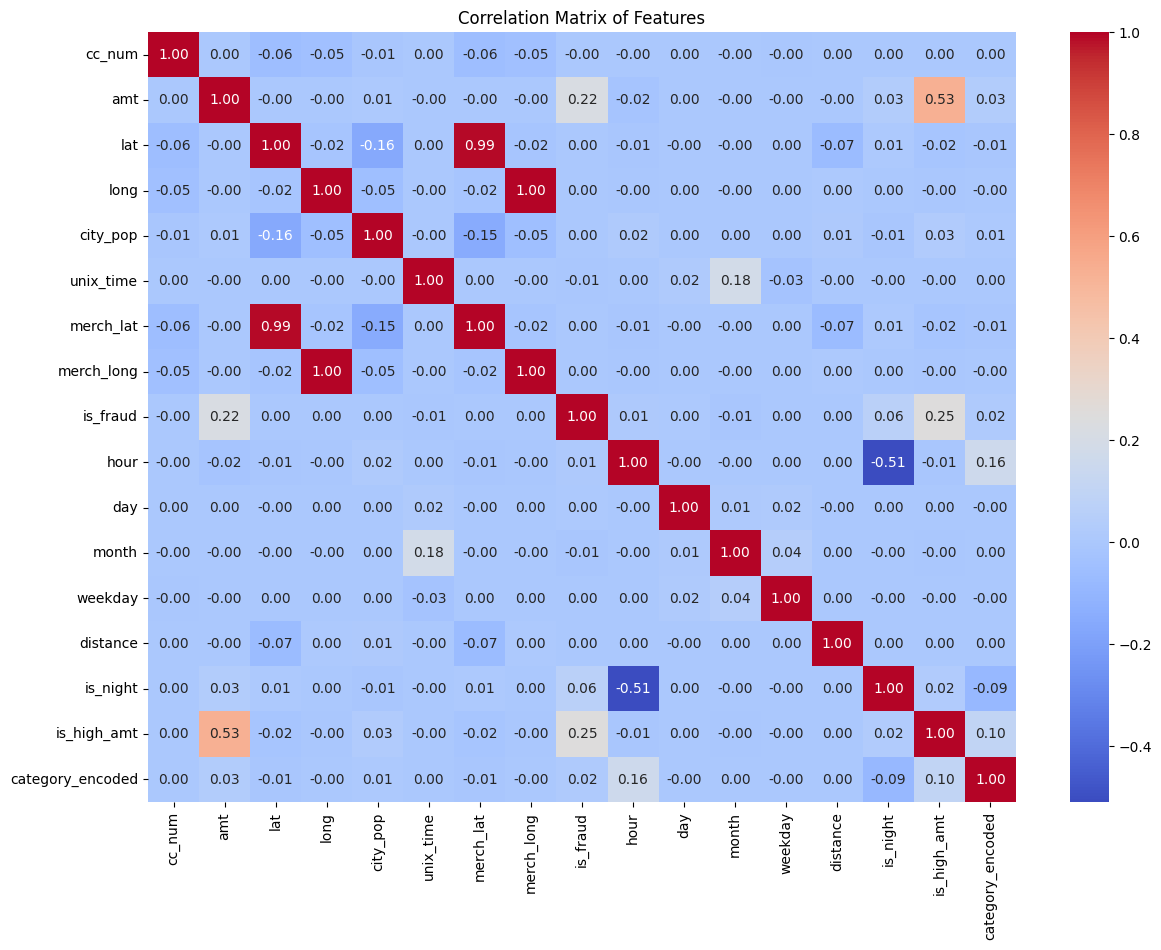

In [18]:
plt.figure(figsize=(14,10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()

In [19]:
# Dynamic Feature Selection based on statistics
engineered_features = []

In [20]:
# Include only if standard deviation is significant
if df['amt'].std() > 5:
    engineered_features.append('amt')

In [21]:
# Include distance if it's not constant
if df['distance'].nunique() > 1:
    engineered_features.append('distance')

In [22]:
# Include binary flags if balanced enough
if df['is_night'].value_counts(normalize=True).min() > 0.05:
    engineered_features.append('is_night')
if df['is_high_amt'].value_counts(normalize=True).min() > 0.05:
    engineered_features.append('is_high_amt')

In [23]:
# Include hour and weekday only if there is spread
if df['hour'].nunique() > 4:
    engineered_features.append('hour')
if df['weekday'].nunique() > 2:
    engineered_features.append('weekday')

In [24]:
# Categorical encoding
if 'category_encoded' in df.columns and df['category_encoded'].nunique() > 1:
    engineered_features.append('category_encoded')
for i in engineered_features:
   +print("Selected engineered feature:", i)

X = df[engineered_features]
y = df['is_fraud']


Selected engineered feature: amt
Selected engineered feature: distance
Selected engineered feature: is_night
Selected engineered feature: hour
Selected engineered feature: weekday
Selected engineered feature: category_encoded


In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [26]:
# Recursive Feature Elimination with Cross-Validation
rfe_estimator = LogisticRegression(class_weight='balanced', max_iter=1000)
rfe_selector = RFECV(estimator=rfe_estimator, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
rfe_selector.fit(X_train, y_train)
selected_features = X_train.columns[rfe_selector.support_].tolist()
print("Selected Features via RFECV:", selected_features)


Selected Features via RFECV: ['amt', 'is_night', 'hour', 'weekday', 'category_encoded']


In [27]:
# Fit best model from RFECV on selected features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

In [37]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n==== {name} ====")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy)
    print("ROC AUC Score:", roc_auc)
    print("R2 Score:", r2)
    print("MSE:", mse)
    print("RMSE:", rmse)

    return {
        "Model": name,
        "Accuracy": accuracy,
        "ROC AUC": roc_auc,
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse
    }


In [29]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_sel, y_train)
evaluate_model("Logistic Regression", lr_model, X_test_sel, y_test)



==== Logistic Regression ====
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.00      0.00      0.00      1501

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335

Accuracy: 0.9937146933502998
ROC AUC Score: 0.9020012034143903
R2 Score: -0.09226460189795072
MSE: 0.006285306649700195
RMSE: 0.07927992589363461


{'Model': 'Logistic Regression',
 'Accuracy': 0.9937146933502998,
 'ROC AUC': np.float64(0.9020012034143903),
 'R2': -0.09226460189795072,
 'MSE': 0.006285306649700195,
 'RMSE': np.float64(0.07927992589363461)}

In [30]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_sel, y_train)
evaluate_model("Decision Tree", dt_model, X_test_sel, y_test)



==== Decision Tree ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.70      0.70      0.70      1501

    accuracy                           1.00    259335
   macro avg       0.85      0.85      0.85    259335
weighted avg       1.00      1.00      1.00    259335

Accuracy: 0.9965257292690921
ROC AUC Score: 0.8485513834549833
R2 Score: 0.39623901453370947
MSE: 0.003474270730907899
RMSE: 0.05894294470848822


{'Model': 'Decision Tree',
 'Accuracy': 0.9965257292690921,
 'ROC AUC': np.float64(0.8485513834549833),
 'R2': 0.39623901453370947,
 'MSE': 0.003474270730907899,
 'RMSE': np.float64(0.05894294470848822)}

In [31]:

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_sel, y_train)
evaluate_model("Random Forest", rf_model, X_test_sel, y_test)



==== Random Forest ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.79      0.70      0.74      1501

    accuracy                           1.00    259335
   macro avg       0.90      0.85      0.87    259335
weighted avg       1.00      1.00      1.00    259335

Accuracy: 0.9972082441629553
ROC AUC Score: 0.9506438023582687
R2 Score: 0.5148468884821372
MSE: 0.002791755837044749
RMSE: 0.05283706877793988


{'Model': 'Random Forest',
 'Accuracy': 0.9972082441629553,
 'ROC AUC': np.float64(0.9506438023582687),
 'R2': 0.5148468884821372,
 'MSE': 0.002791755837044749,
 'RMSE': np.float64(0.05283706877793988)}

In [32]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_sel, y_train)
evaluate_model("XGBoost", xgb_model, X_test_sel, y_test)

c:\Users\PC WORLD\Desktop\creditcard\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:32:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



==== XGBoost ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.85      0.70      0.77      1501

    accuracy                           1.00    259335
   macro avg       0.92      0.85      0.88    259335
weighted avg       1.00      1.00      1.00    259335

Accuracy: 0.9975475736017121
ROC AUC Score: 0.9881336106658486
R2 Score: 0.5738157749649714
MSE: 0.002452426398287929
RMSE: 0.04952197894155613


{'Model': 'XGBoost',
 'Accuracy': 0.9975475736017121,
 'ROC AUC': np.float64(0.9881336106658486),
 'R2': 0.5738157749649714,
 'MSE': 0.002452426398287929,
 'RMSE': np.float64(0.04952197894155613)}

In [33]:
# Collect all model results
results = []
results.append(evaluate_model("Logistic Regression", lr_model, X_test_sel, y_test))
results.append(evaluate_model("Decision Tree", dt_model, X_test_sel, y_test))
results.append(evaluate_model("Random Forest", rf_model, X_test_sel, y_test))
results.append(evaluate_model("XGBoost", xgb_model, X_test_sel, y_test))

# Show as a DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)



==== Logistic Regression ====
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.00      0.00      0.00      1501

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335

Accuracy: 0.9937146933502998
ROC AUC Score: 0.9020012034143903
R2 Score: -0.09226460189795072
MSE: 0.006285306649700195
RMSE: 0.07927992589363461

==== Decision Tree ====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.70      0.70      0.70      1501

    accuracy                           1.00    259335
   macro avg       0.85      0.85      0.85    259335
weighted avg       1.00      1.00      1.00    259335

Accuracy: 0.9965257292690921
ROC AUC Score: 0.8485513834549833
R2 Score: 0.39623901453370947
MSE: 0.003474270730907899
RMSE: 0.05894294470848822

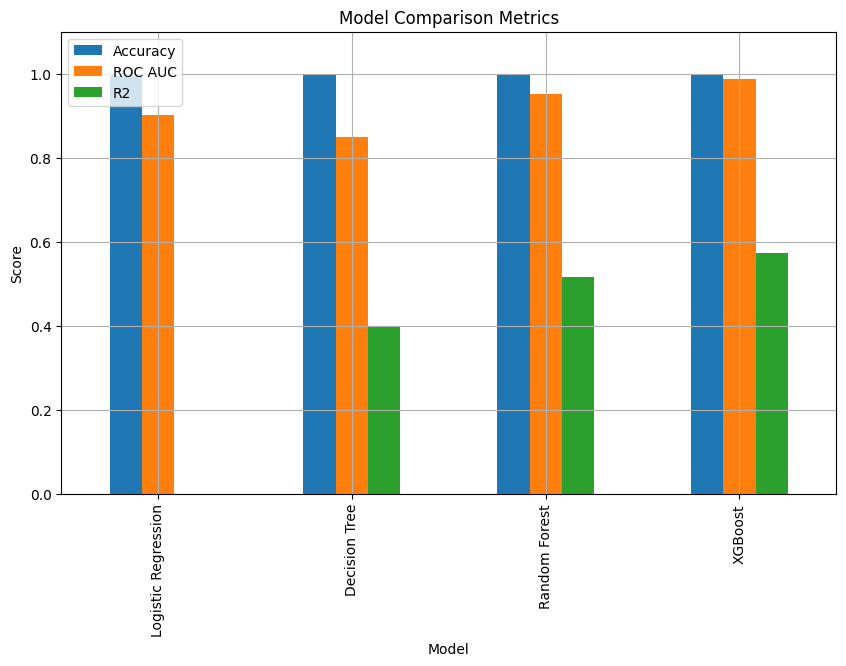

In [34]:
results_df.set_index('Model')[['Accuracy', 'ROC AUC', 'R2']].plot(kind='bar', figsize=(10,6), title='Model Comparison Metrics')
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()


In [36]:
# 3. Convert to DataFrame and display
results_df = pd.DataFrame(results)

print("\nModel Performance Comparison Table:")
display(results_df)



Model Performance Comparison Table:


,Model,Accuracy,ROC AUC,R2,MSE,RMSE
0,Logistic Regression,0.993715,0.902001,-0.092265,0.006285,0.079280
1,Decision Tree,0.996526,0.848551,0.396239,0.003474,0.058943
2,Random Forest,0.997208,0.950644,0.514847,0.002792,0.052837
3,XGBoost,0.997548,0.988134,0.573816,0.002452,0.049522


In [6]:
cat_col=['merchant','category','gender']
encoder={}
for col in cat_col:
    encoder[col]=LabelEncoder()
    df[col]=encoder[col].fit_transform(df[col])

In [7]:
def harversine(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])
df['distance']=harversine(df['lat'],df['long'],df['merch_lat'],df['merch_long'])

In [8]:
feature=['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x=df[feature]
y=df['is_fraud']

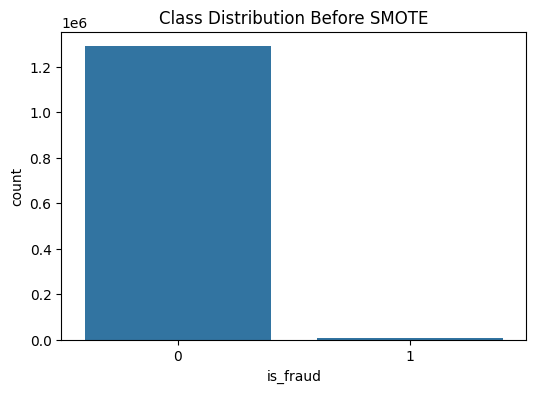

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud',data=df)
plt.title("Class Distribution Before SMOTE")
plt.show()

In [10]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
x_resample,y_resample=smote.fit_resample(x,y)

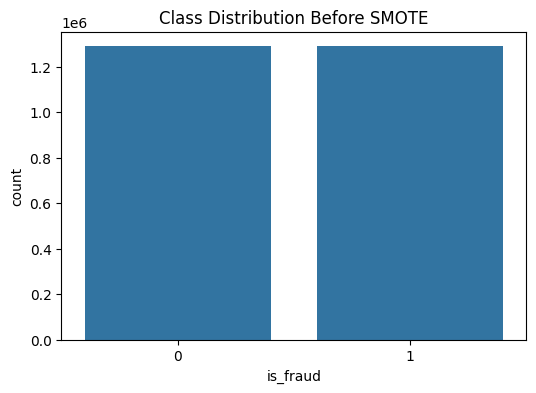

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution Before SMOTE")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_resample,y_resample,test_size=0.2,random_state=42)

In [13]:
import lightgbm as lgb
lbg_model=lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    is_unbalance=True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=1,
    n_estimators=200
)
lbg_model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=1,
               metrics='auc', n_estimators=200, objective='binary')

In [14]:
y_pred=lbg_model.predict(x_test)

In [15]:
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,roc_curve,auc
print("classification_report:\n",classification_report(y_test,y_pred))
print("Roc AUC Score: ",roc_auc_score(y_test,y_pred))

classification_report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88    257186
           1       0.95      0.79      0.86    258482

    accuracy                           0.87    515668
   macro avg       0.88      0.87      0.87    515668
weighted avg       0.88      0.87      0.87    515668

Roc AUC Score:  0.8705875259208415


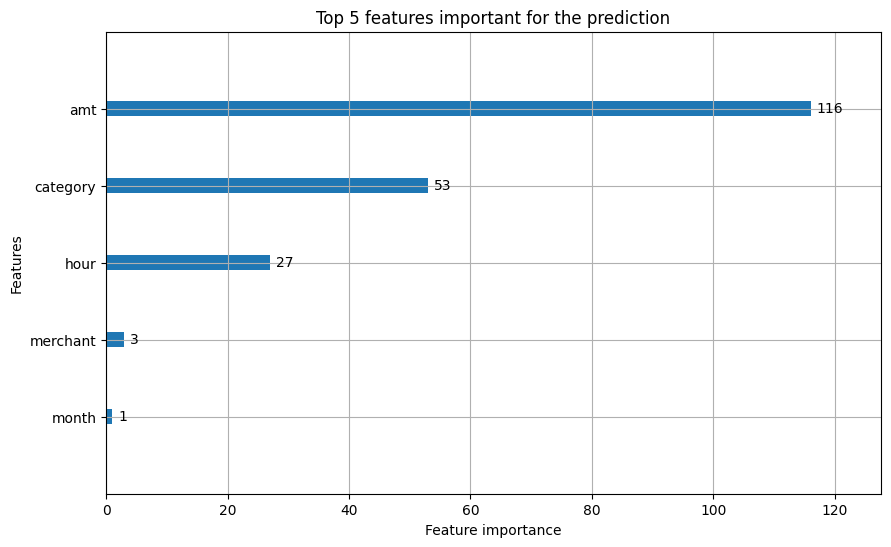

In [20]:
lgb.plot_importance(lbg_model,max_num_features=10,importance_type='split',figsize=(10,6))
plt.title("Top 5 features important for the prediction")
plt.show()

In [17]:
from sklearn.metrics import auc


fpr,tpr,thresholds=roc_curve(y_test,lbg_model.predict_proba(x_test)[:,1])
roc_auc=auc(fpr,tpr)

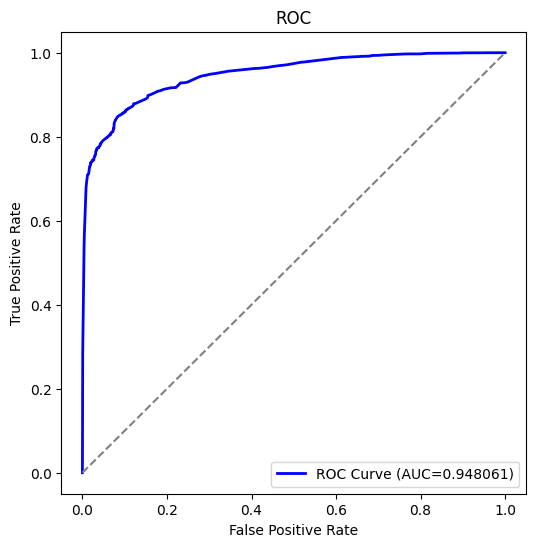

In [18]:
from matplotlib import pyplot as plt


plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,color='blue',lw=2,label=f'ROC Curve (AUC={roc_auc:2f})')
plt.plot([0,1],[0,1],color='gray',linestyle='--')
plt.title("ROC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [21]:
df[df['is_fraud']==1].head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
2449,4613314721966,543,4,281.06,1,35.9946,-81.7266,885,1988-09-15,1325466397,36.430124,-81.179483,1,1,2,1,68.962726
2472,340187018810220,285,2,11.52,0,29.4400,-98.4590,1595797,1960-10-28,1325468849,29.819364,-99.142791,1,1,2,1,78.443229
2523,340187018810220,196,4,276.31,0,29.4400,-98.4590,1595797,1960-10-28,1325473523,29.273085,-98.836360,1,3,2,1,41.048425
2546,4613314721966,162,2,7.03,1,35.9946,-81.7266,885,1988-09-15,1325475483,35.909292,-82.091010,1,3,2,1,34.211963
2553,340187018810220,328,4,275.73,0,29.4400,-98.4590,1595797,1960-10-28,1325476547,29.786426,-98.683410,1,3,2,1,44.124854


In [19]:
from sklearn.preprocessing import LabelEncoder
import joblib
joblib.dump(lbg_model,"fraud_detection_model.jb")
joblib.dump(encoder,"label_encoder.jb")

['label_encoder.jb']